See rendered plots by using https://nbviewer.org/ (notebook has to be in a public repository for this to work, which is why it's not in the other one)

In [6]:
import pandas as pd
import numpy as np
#import glob
#import os
#from PIL import Image
from matplotlib.colors import Normalize
from matplotlib import cm
from plotly.subplots import make_subplots
from datetime import datetime as dt
from datetime import timedelta as td
import plotly.graph_objects as go
import plotly.express as px
from visualization_tools import *
from flare_physics_utils import *
from sunpy_map_utils import *
import plotly.figure_factory as ff
import seaborn as sns

In [265]:
%matplotlib notebook

In [7]:
import pride_colors
set_pride_template()

In [84]:
rsun=695700000 * u.m
rsun_arcsec=cm_to_arcsec(rsun.to(u.cm)).value

In [30]:
df=pd.read_csv('data/HEK_bproj_CFL_coords_rotated_updated5.csv')
#df=pd.read_csv('HEK_bproj_CFL_STEREO_rotated2.csv')
df['Datetime']=pd.to_datetime(df.Datetime)
df['event_peaktime']=pd.to_datetime(df.event_peaktime)

In [31]:
df.Datetime.describe()

/Users/wheatley/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                           2303
unique                           623
top       2021-08-26 23:23:20.849099
freq                              64
first     2021-01-01 04:46:57.762734
last      2021-09-15 20:59:05.620260
Name: Datetime, dtype: object

In [32]:
df.fl_goescls.head(10)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7    B5.0
8    B5.0
9     NaN
Name: fl_goescls, dtype: object

In [33]:
df['HEK_GOES_flux']=[goes_class_to_flux(str(g)) if type(g)==str else 1e-10 for g in df.fl_goescls]
df['HEK_GOES_letter']=[str(g)[:1] if type(g)==str else None for g in df.fl_goescls]

In [34]:
df['STIX_GOES_flux']=[goes_class_to_flux(str(g)) if type(g)==str else 1e-10 for g in df.GOES_CLASS]
df['STIX_GOES_letter']=[str(g)[:1] if type(g)==str else None for g in df.GOES_CLASS]

In [35]:
df['Bproj_peak_binned']=[np.round(p,decimals=-1) for p in df.Bproj_peak] #round to 10s

In [36]:
df.keys()

Index(['Unnamed: 0', 'Datetime', 'hpc_x', 'hpc_y', 'hpc_x_in', 'hpc_y_in',
       'hpc_x_arcsec', 'hpc_y_arcsec', 'hpc_x_deg', 'hpc_y_deg',
       'hpc_rsun_apparent', 'hpc_rotated_x_arcsec', 'hpc_rotated_y_arcsec',
       'hpc_rotated_lon_deg', 'hpc_rotated_lat_deg', 'CFL_vis_from_Earth',
       'Bproj_vis_from_Earth', 'AIA_vis_from_SO', 'Bproj_lon', 'Bproj_lat',
       'CFL_lon', 'CFL_lat', 'Bproj_rotated_x_arcsec',
       'Bproj_rotated_y_arcsec', 'Bproj_rotated_lon_deg',
       'Bproj_rotated_lat_deg', 'CFL_rotated_x_arcsec', 'CFL_rotated_y_arcsec',
       'CFL_rotated_lon_deg', 'CFL_rotated_lat_deg', 'hpc_bbox',
       'frm_identifier', 'frm_name', 'fl_goescls', 'fl_peaktempunit',
       'fl_peakemunit', 'fl_peakflux', 'event_peaktime', 'fl_peakfluxunit',
       'fl_peakem', 'fl_peaktemp', 'obs_dataprepurl', 'gs_imageurl',
       'gs_thumburl', 'Datetime_SO', 'Duration(s)', 'Bproj_peak', 'Bproj_x',
       'Bproj_y', 'Unnamed: 0.1', 'id', 'RAW_FILE_ID', 'PEAK_UTC',
       'PEAK_COU

In [37]:
ckeys=['hpc_x', 'hpc_y', 'hpc_rotated_x_arcsec', 'hpc_rotated_y_arcsec',
    'Bproj_lon', 'Bproj_lat', 'CFL_lon', 'CFL_lat', 'Bproj_rotated_x_arcsec',
       'Bproj_rotated_y_arcsec','CFL_rotated_x_arcsec', 'CFL_rotated_y_arcsec',
       'CFL_rotated_lon_deg', 'CFL_rotated_lat_deg','Bproj_x', 'Bproj_y','CFL_LOC_X(arcsec)', 'CFL_LOC_Y (arcsec)',
       'hpc_rotated_lon_deg', 'hpc_rotated_lat_deg']
aiakeys=['hpc_x', 'hpc_y','hpc_x_px', 'hpc_y_px', 'hpc_x_rotated', 'hpc_y_rotated',
       'x_px_rotated', 'y_px_rotated','hpc_lon_rotated', 'hpc_lat_rotated', 'hpc_lon', 'hpc_lat']
bprojkeys=['Bproj_lon', 'Bproj_lat','Bproj_x_rotated', 'Bproj_y_rotated','Bproj_x', 'Bproj_y']
cflkeys=['CFL_lon', 'CFL_lat','CFL_lon_rotated', 'CFL_lat_rotated','CFL_LOC_X(arcsec)', 'CFL_LOC_Y (arcsec)']

In [38]:
df['Month']=df.Datetime.dt.month
df['timedelta_abs']=[np.abs(t) for t in df['STIX-AIA_timedelta_s']]

In [39]:
gdf=df.groupby('Month')

In [40]:
df['within200oflimb']=[within_r_of_center(200,(x,y)) for x,y in zip(df.hpc_x,df.hpc_y)]

In [41]:
sdf0=df.where(df['STIX-AIA_timedelta_s'] >=-500).dropna(how='all')
sdf1=sdf0.where(sdf0['STIX-AIA_timedelta_s'] <=500).dropna(how='all')
sdf=sdf1.where(sdf1.within200oflimb==True).dropna(how='all')
sdf['STIX-AIA_timedelta_s'].describe()

count    860.000000
mean     125.852895
std      207.262210
min     -474.040497
25%        2.410718
50%      117.849099
75%      292.811068
max      497.569916
Name: STIX-AIA_timedelta_s, dtype: float64

## Histograms - coordinates

<AxesSubplot:ylabel='Count'>

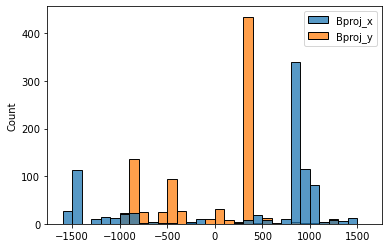

In [43]:
sns.histplot(sdf[['Bproj_x','Bproj_y']],binwidth=100,binrange=[-1600,1600])

<AxesSubplot:ylabel='Count'>

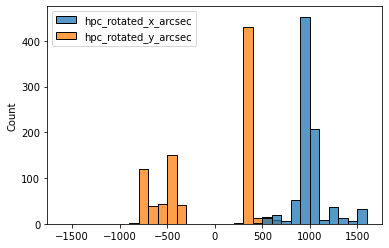

In [44]:
sns.histplot(sdf[['hpc_rotated_x_arcsec','hpc_rotated_y_arcsec']],binwidth=100,binrange=[-1600,1600])

<AxesSubplot:ylabel='Count'>

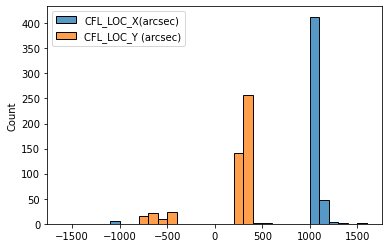

In [45]:
sns.histplot(sdf[['CFL_LOC_X(arcsec)','CFL_LOC_Y (arcsec)']],binwidth=100,binrange=[-1600,1600])

## Histograms - other properties

In [46]:
#note this is without dropping duplicates in Datetime!
fig=go.Figure()
fig.add_trace(go.Bar(y=sdf.groupby('Month')['Month'].count()))
fig.update_layout(xaxis=dict(title='Month',tickvals=list(range(8)),ticktext=['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept']),yaxis_title='Events')

In [47]:
aa=sdf.groupby(['Month','HEK_GOES_letter'])['Datetime'].count()

In [48]:
mlabels=['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept']

In [49]:
fig=go.Figure()
for i in np.linspace(2.0,9.0,8):
    fig.add_trace(go.Bar(x=aa[i].keys(), y=aa[i].values,name=mlabels[int(i)-2]))
fig.update_layout(barmode='stack',title='HEK GOES classes when available')
#fig.add_trace(go.Bar(y=sdf.groupby('Month')['STIX_GOES_flux'].mean()))
#fig.update_layout(xaxis=dict(title='Month',tickvals=list(range(8)),ticktext=['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept']),yaxis_title='Events')

In [50]:
bb=sdf.groupby(['Month','STIX_GOES_letter'])['Datetime'].count()
fig=go.Figure()
for i in np.linspace(2.0,9.0,8):
    try:
        fig.add_trace(go.Bar(x=bb[i].keys(), y=bb[i].values,name=mlabels[int(i)-2]))
    except KeyError:
        continue
fig.update_layout(barmode='stack',title='STIX GOES classes when available')

In [51]:
cc=sdf.groupby(['Month','Bproj_peak_binned'])['Datetime'].count()
fig=go.Figure()
for i in np.linspace(2.0,9.0,8):
    try:
        fig.add_trace(go.Bar(x=cc[i].keys(), y=cc[i].values,name=mlabels[int(i)-2]))
    except KeyError:
        continue
fig.update_layout(barmode='stack',title='Bproj peak counts',xaxis_title='Bproj peak counts')

## All Events - Solar Orbiter View
- excluding events close to the AIA limb which might not have been rotated properly. ie, AIA is not greater than 200" from the limb
- also excluding events where CFL_x = CFL_y

In [52]:
fdf=df.query('CFL_lon != CFL_lat').dropna(how='all')

In [53]:
odf=df.where(df.within200oflimb==True).dropna(how='all')

In [54]:
peak_counts=fdf['PEAK_COUNTS (4s)'].fillna(1)

In [55]:
df.fl_goescls.replace(np.nan,'',inplace=True)
df.fl_goescls

0        
1        
2        
3        
4        
       ..
2298     
2299     
2300     
2301     
2302     
Name: fl_goescls, Length: 2303, dtype: object

In [57]:
df['short_image_url']=[s[s.find('/data')+6:] if type(s) == str else None for s in df.gs_imageurl]

In [58]:
df.short_image_url.replace(np.nan,'',inplace=True)

In [59]:
fig=go.Figure()
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-90, y0=-90, x1=90, y1=90,
    line_color="LightSeaGreen",)

#hovertext data and templates
dtfmt=df.Datetime.dt.strftime("%Y-%m-%d %H:%M:%S")
bcdata=np.vstack([df['Bproj_peak'],dtfmt]).T
ccdata=np.vstack([df['PEAK_COUNTS (4s)'],df['GOES_CLASS'],dtfmt]).T
acdata=np.vstack([df.fl_goescls,dtfmt,df.short_image_url]).T
#scdata=np.vstack([df.peak_flux_x,df.peak_flux_y,dtfmt]).T
btemp='%{customdata[1]}<br>x: %{x:.2f}, y: %{y:.2f}<br>Peak: %{customdata[0]:.2f}'
ctemp='%{customdata[2]}<br>x: %{x:.2f}, y: %{y:.2f}<br>Peak Counts (4s): %{customdata[0]:.2f}<br>%{customdata[1]}'
atemp='%{customdata[2]}<br>x: %{x:.2f}, y: %{y:.2f}<br> %{customdata[0]}<br>%{customdata[1]}'
#stemp='x: %{x:.2f}, y: %{y:.2f}<br>STEREO x: %{customdata[0]}<br>STEREO y:%{customdata[1]}<br>%{customdata[2]}'

fig.add_trace(go.Scatter(x=df['Bproj_lon'],y=df['Bproj_lat'],name='Back Projection',marker_size=np.log10(df['Bproj_peak']*100)*5,mode='markers',customdata=bcdata,hovertemplate=btemp)) #can update traces later
fig.add_trace(go.Scatter(x=fdf['CFL_lon'],y=fdf['CFL_lat'],name='CFL',marker_size=np.log10(peak_counts)*5,mode='markers',customdata=ccdata,hovertemplate=ctemp)) #can update traces later
fig.add_trace(go.Scatter(x=odf['hpc_rotated_lon_deg'],y=odf['hpc_rotated_lat_deg'],name='AIA/HEK',marker_size=-2*np.log10(odf['HEK_GOES_flux']),mode='markers',customdata=acdata,hovertemplate=atemp)) #can update traces later
#fig.add_trace(go.Scatter(x=odf['stereo_rotated_lon'],y=odf['stereo_rotated_lat'],name='STEREO-A',marker_size=-2*np.log10(odf['HEK_GOES_flux']),mode='markers',customdata=scdata,hovertemplate=stemp)) #can update traces later

fig.update_layout(height=650)
fig.update_xaxes(range=[-100,100],showgrid=False,zeroline=False)
fig.update_yaxes(range=[-100,100],scaleanchor='x',scaleratio=1,showgrid=False)
fig.update_layout(xaxis_title='HPR_lon (deg)',yaxis_title='HPR_lat (deg)',title='Flare Locations as seen by Solar Orbiter')

## All Events - Earth View

excluding events close to the AIA limb which might not have been rotated properly. ie, AIA is not greater than 200" from the limb



In [85]:
fig=go.Figure()
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-rsun_arcsec, y0=-rsun_arcsec, x1=rsun_arcsec, y1=rsun_arcsec,
    line_color="LightSeaGreen",)

fig.add_trace(go.Scatter(x=df['Bproj_rotated_x_arcsec'],y=df['Bproj_rotated_y_arcsec'],name='Back Projection',marker_size=np.log10(df['Bproj_peak']*100)*7,mode='markers',customdata=bcdata,hovertemplate=btemp)) #can update traces later
fig.add_trace(go.Scatter(x=df['CFL_rotated_x_arcsec'],y=df['CFL_rotated_y_arcsec'],name='CFL',marker_size=np.log10(peak_counts)*5,mode='markers',customdata=ccdata,hovertemplate=ctemp)) #can update traces later
fig.add_trace(go.Scatter(x=odf['hpc_x'],y=odf['hpc_y'],name='AIA/HEK',marker_size=-1.5*np.log10(odf['HEK_GOES_flux']),mode='markers',customdata=acdata,hovertemplate=atemp)) #can update traces later

fig.update_layout(height=650)
fig.update_xaxes(range=[-1000,1000],showgrid=False,zeroline=False)
fig.update_yaxes(range=[-1000,1000],scaleanchor='x',scaleratio=1,showgrid=False)
fig.update_layout(xaxis_title='HPC_x (arcsec)',yaxis_title='HPC_y (arcsec)',title='Flare Locations as seen by Earth')

## Row-by-row test

In [61]:
kkeys=ckeys.copy()
kkeys.append('STIX_GOES_flux')
kkeys.append('HEK_GOES_flux')
kkeys.append('GOES_CLASS')
kkeys.append('Bproj_peak')
kkeys.append('fl_goescls')
kkeys.append('Datetime')
kkeys.append('STIX-AIA_timedelta_s')
kkeys.append('Month')

In [62]:
sdf.sort_values(by='timedelta_abs')[['Datetime','event_peaktime','STIX-AIA_timedelta_s']].head()

Datetime      event_peaktime  STIX-AIA_timedelta_s
1097 2021-05-22 03:02:24.410718 2021-05-22 03:02:22              2.410718
1096 2021-05-22 03:02:24.410718 2021-05-22 03:02:22              2.410718
1095 2021-05-22 03:02:24.410718 2021-05-22 03:02:22              2.410718
1094 2021-05-22 03:02:24.410718 2021-05-22 03:02:22              2.410718
1279 2021-05-22 15:39:48.017871 2021-05-22 15:39:53             -4.982129

In [63]:
rdf=sdf.sort_values(by='timedelta_abs').groupby(sdf.Datetime)[kkeys].agg('first')

In [64]:
rdf.Bproj_peak.describe()

count    115.000000
mean      14.291679
std       32.197769
min        0.079412
25%        0.339791
50%        0.889833
75%       12.750468
max      229.481830
Name: Bproj_peak, dtype: float64

In [65]:
rdf2=rdf.where(rdf.Bproj_peak >=1).dropna(how='all')
rdf2.reset_index(drop=True,inplace=True)

In [66]:
rdf.Datetime.to_csv('AIA-STEREO-SO_event_datetimes2.csv')

In [67]:
rdf.reset_index(drop=True,inplace=True)

In [68]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   hpc_x                   115 non-null    float64       
 1   hpc_y                   115 non-null    float64       
 2   hpc_rotated_x_arcsec    115 non-null    float64       
 3   hpc_rotated_y_arcsec    115 non-null    float64       
 4   Bproj_lon               115 non-null    float64       
 5   Bproj_lat               115 non-null    float64       
 6   CFL_lon                 54 non-null     float64       
 7   CFL_lat                 54 non-null     float64       
 8   Bproj_rotated_x_arcsec  90 non-null     float64       
 9   Bproj_rotated_y_arcsec  90 non-null     float64       
 10  CFL_rotated_x_arcsec    2 non-null      float64       
 11  CFL_rotated_y_arcsec    2 non-null      float64       
 12  CFL_rotated_lon_deg     2 non-null      float64   

In [89]:
ccolors = pride_colors_plotly(flag='rainbow',continuous_colorscale=True,ncolors=60)
cround=[]
for c in ccolors:
    rval=float(c[4:c.find(',')])
    bval=float(c[c.find(',')+1:c.rfind(',')])
    gval=float(c[c.rfind(',')+1:-1])
    rounded='rgb(%s,%s,%s)' % (int(rval),int(bval),int(gval))
    cround.append(rounded)

In [90]:
fig=go.Figure()
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-90, y0=-90, x1=90, y1=90,
    line_color="LightSeaGreen",)
markersym=['x','circle','star']
line=dict(dash='dot',width=.5)
for i,row in rdf2.iterrows(): #ones where times are within 5 min
    xx=row[['CFL_lon','Bproj_lon','hpc_rotated_lon_deg']]
    yy=row[['CFL_lat','Bproj_lat','hpc_rotated_lat_deg']]
    if xx['CFL_lon']==yy['CFL_lat']: #that's wrong
        xx['CFL_lon']=None
        yy['CFL_lat']=None
    #xx.replace(np.nan,None,inplace=True)
    #yy.replace(np.nan,None,inplace=True)
    msizes=pd.to_numeric(row[['STIX_GOES_flux','STIX_GOES_flux','HEK_GOES_flux']])
    #msizes=msizes.replace(0.0,10.)
    #print(21-(-np.log10(msizes)),msizes)
    #print(xx,yy)
    fig.add_trace(go.Scatter(x=xx,y=yy,name=str(row.Datetime)[:-7],
                             marker=dict(size=20-(-np.log10(msizes)),symbol=markersym,color=cround[i]),line=line,
                            legendgroup=row.Month,legendgrouptitle_text=row.Datetime.strftime('%b'))) #can update traces later
    #if i== 20:
    #    break
fig.update_layout(height=650)
fig.update_xaxes(showgrid=False,zeroline=False)
fig.update_yaxes(scaleanchor='x',scaleratio=1,showgrid=False)
fig.update_layout(xaxis_title='HPC_X (deg)',yaxis_title='HPC_Y (deg)',title='Flare Locations as seen by Solar Orbiter')
#fig.update_layout(height=600,width=700)

most events in August/September appear to be very small (Bproj_peak <5) and very close to the limb. so then it's not too suprising that the AIA locations fail to match... probably the Bproj locations themselves are not very reliable

In [72]:
fig=go.Figure()
#fig.add_trace(go.Scatter(x=rdf.Bproj_x,y=rdf.Bproj_y,name=rdf.Datetime)) #can update traces later
#fig.add_trace(go.Scatter(x=rdf.hpc_rotated_x_arcsec,y=hpc.rotated_y_arcsec,name=rdf.Datetime)) #can update traces later
fig.add_trace(go.Scatter(x=rdf.Datetime,y=rdf.Bproj_y,name='Bproj',mode='markers')) #can update traces later
fig.add_trace(go.Scatter(x=rdf.Datetime,y=rdf.hpc_rotated_y_arcsec,name='AIA rotated',mode='markers')) #can update traces later


In [73]:
fig=go.Figure()
#fig.add_trace(go.Scatter(x=rdf.Bproj_x,y=rdf.Bproj_y,name=rdf.Datetime)) #can update traces later
#fig.add_trace(go.Scatter(x=rdf.hpc_rotated_x_arcsec,y=hpc.rotated_y_arcsec,name=rdf.Datetime)) #can update traces later
fig.add_trace(go.Scatter(x=rdf.Datetime,y=rdf.Bproj_x,name='Bproj',mode='markers')) #can update traces later
fig.add_trace(go.Scatter(x=rdf.Datetime,y=rdf.hpc_rotated_x_arcsec,name='AIA rotated',mode='markers')) #can update traces later
fig.add_trace(go.Scatter(x=rdf.Datetime,y=rdf.Bproj_lon,name='Bproj',mode='markers')) #can update traces later
fig.add_trace(go.Scatter(x=rdf.Datetime,y=rdf.hpc_rotated_lon_deg,name='AIA rotated',mode='markers')) #can update traces later


In [91]:
ccolors = pride_colors_plotly(flag='rainbow',continuous_colorscale=True,ncolors=120)
cround=[]
for c in ccolors:
    rval=float(c[4:c.find(',')])
    bval=float(c[c.find(',')+1:c.rfind(',')])
    gval=float(c[c.rfind(',')+1:-1])
    rounded='rgb(%s,%s,%s)' % (int(rval),int(bval),int(gval))
    cround.append(rounded)

In [92]:
fig=go.Figure()
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-rsun_arcsec, y0=-rsun_arcsec, x1=rsun_arcsec, y1=rsun_arcsec,
    line_color="LightSeaGreen",)
markersym=['x','circle','star']
line=dict(dash='dot',width=.5)
for i,row in rdf.iterrows(): #ones where times are within 5 min
    xx=row[['CFL_rotated_x_arcsec','Bproj_rotated_x_arcsec','hpc_x']]
    yy=row[['CFL_rotated_y_arcsec','Bproj_rotated_y_arcsec','hpc_y']]
    if xx['CFL_rotated_x_arcsec']==yy['CFL_rotated_y_arcsec']: #that's wrong
        xx['CFL_rotated_x_arcsec']=None
        yy['CFL_rotated_y_arcsec']=None
    #xx.replace(np.nan,None,inplace=True)
    #yy.replace(np.nan,None,inplace=True)
    msizes=pd.to_numeric(row[['STIX_GOES_flux','STIX_GOES_flux','HEK_GOES_flux']])
    #msizes=msizes.replace(0.0,10.)
    #print(21-(-np.log10(msizes)),msizes)
    #print(xx,yy)
    fig.add_trace(go.Scatter(x=xx,y=yy,name=str(row.Datetime)[:-7],
                             marker=dict(size=20-(-np.log10(msizes)),symbol=markersym,color=cround[i]),line=line,
                            legendgroup=row.Month,legendgrouptitle_text=row.Datetime.strftime('%b'))) #can update traces later
    #if i== 20:
    #    break
fig.update_layout(height=650)
fig.update_xaxes(range=[-1000,1000],showgrid=False,zeroline=False)
fig.update_yaxes(range=[-1000,1000],scaleanchor='x',scaleratio=1,showgrid=False)
fig.update_layout(xaxis_title='HPC_x (arcsec)',yaxis_title='HPC_y (arcsec)',title='Flare Locations as seen by Earth')

# Density Maps of offsets

In [76]:
#boundaries - lon/lat differences within +-100, x/y within 1000
bpcflxy=sdf.query("Bproj_CFL_x_diff < 1000 and Bproj_CFL_x_diff > -1000 and Bproj_CFL_y_diff > -1000 and Bproj_CFL_y_diff < 1000")

In [77]:
fig = ff.create_2d_density(
    bpcflxy.Bproj_CFL_x_diff, bpcflxy.Bproj_CFL_y_diff, colorscale='Blues',
    hist_color=cround[-1], point_size=5,ncontours=10,title='Back Projection and CFL Location Differences')
fig.update_layout(xaxis_title='x offset (arcsec)')
fig.update_layout(yaxis_title='y offset (arcsec)')
fig.show()

In [334]:
#boundaries - lon/lat differences within +-100, x/y within 1000
# bpaia=sdf.query("Bproj_AIA_lon_diff < 100 and Bproj_AIA_lon_diff > -100 and Bproj_AIA_lat_diff > -100 and Bproj_AIA_lat_diff < 100")
# fig = ff.create_2d_density(
#     bpaia.Bproj_AIA_lon_diff, bpaia.Bproj_AIA_lat_diff, colorscale='Blues',
#     hist_color=cround[-1], point_size=5,ncontours=10,title='Back Projection and AIA Location Differences')
# fig.update_layout(xaxis_title='lon offset (deg)')
# fig.update_layout(yaxis_title='lat offset (deg)')
# fig.show()

In [78]:
#boundaries - lon/lat differences within +-100, x/y within 1000
bpaiaxy=sdf.query("Bproj_AIA_x_diff < 1000 and Bproj_AIA_x_diff > -1000 and Bproj_AIA_y_diff > -1000 and Bproj_AIA_y_diff < 1000")
print(bpaiaxy.Datetime.count())
fig = ff.create_2d_density(
    bpaiaxy.Bproj_AIA_x_diff, bpaiaxy.Bproj_AIA_y_diff, colorscale='Blues',
    hist_color=cround[-1], point_size=5,ncontours=10,title='Back Projection and AIA Location Differences')
fig.update_layout(xaxis_title='x offset (arcsec)')
fig.update_layout(yaxis_title='y offset (arcsec)',xaxis_range=[-100,100],yaxis_range=[-100,100])
fig.show()

614


In [79]:
bpaiaxy=sdf.query("Bproj_AIA_x_diff < 1000 and Bproj_AIA_x_diff > -1000 and Bproj_AIA_y_diff > -1000 and Bproj_AIA_y_diff < 1000 and Month <= 4")
print(bpaiaxy.Datetime.count())
fig = ff.create_2d_density(
    bpaiaxy.Bproj_AIA_x_diff, bpaiaxy.Bproj_AIA_y_diff, colorscale='Blues',
    hist_color=cround[-1], point_size=5,ncontours=10,title='Back Projection and AIA Location Differences - until April 2021')
fig.update_layout(xaxis_title='x offset (arcsec)')
fig.update_layout(yaxis_title='y offset (arcsec)',xaxis_range=[-100,100],yaxis_range=[-300,300])
fig.show()

88


In [80]:
bpaiaxy=sdf.query("Bproj_AIA_x_diff < 1000 and Bproj_AIA_x_diff > -1000 and Bproj_AIA_y_diff > -1000 and Bproj_AIA_y_diff < 1000 and Month > 4")
print(bpaiaxy.Datetime.count())
fig = ff.create_2d_density(
    bpaiaxy.Bproj_AIA_x_diff, bpaiaxy.Bproj_AIA_y_diff, colorscale='Blues',
    hist_color=cround[-1], point_size=5,ncontours=10,title='Back Projection and AIA Location Differences - post April 2021')
fig.update_layout(xaxis_title='x offset (arcsec)',xaxis_range=[-100,100],yaxis_range=[-100,100])
fig.update_layout(yaxis_title='y offset (arcsec)')
fig.show()

526


In [81]:
bpaiaxy=sdf.query("Bproj_AIA_x_diff < 1000 and Bproj_AIA_x_diff > -1000 and Bproj_AIA_y_diff > -1000 and Bproj_AIA_y_diff < 1000 and Month > 7")
print(bpaiaxy.Datetime.count())
fig = ff.create_2d_density(
    bpaiaxy.Bproj_AIA_x_diff, bpaiaxy.Bproj_AIA_y_diff, colorscale='Blues',
    hist_color=cround[-1], point_size=5,ncontours=10,title='Back Projection and AIA Location Differences - post July 2021')
fig.update_layout(xaxis_title='x offset (arcsec)')
fig.update_layout(yaxis_title='y offset (arcsec)')
fig.show()

70


In [82]:
#boundaries - lon/lat differences within +-100, x/y within 1000
bpaiaxy=sdf.query("Month >=4 and Month <8")
print(bpaiaxy.Datetime.count())
fig = ff.create_2d_density(
    bpaiaxy.Bproj_AIA_x_diff, bpaiaxy.Bproj_AIA_y_diff, colorscale='Blues',
    hist_color=cround[-1], point_size=5,ncontours=10,title='Back Projection and AIA Location Differences, April - July')
fig.update_layout(xaxis_title='x offset (arcsec)')
fig.update_layout(yaxis_title='y offset (arcsec)')
fig.show()

563


In [83]:
#boundaries - lon/lat differences within +-100, x/y within 1000
cflaiaxy=sdf.query("(CFL_AIA_x_diff < 1000 and CFL_AIA_x_diff > -1000) and (CFL_AIA_y_diff > -1000 and CFL_AIA_y_diff < 1000)")

fig = ff.create_2d_density(
    cflaiaxy.CFL_AIA_x_diff, cflaiaxy.CFL_AIA_y_diff, colorscale='Blues',
    hist_color=cround[-1], point_size=5,ncontours=10,title='CFL and AIA Location Differences')
fig.update_layout(xaxis_title='x offset (arcsec)')
fig.update_layout(yaxis_title='y offset (arcsec)')
fig.show()

In [335]:
# cflaia=sdf.query("CFL_AIA_lon_diff < 100 and CFL_AIA_lon_diff > -100 and CFL_AIA_lat_diff > -100 and CFL_AIA_lat_diff < 100")

# fig = ff.create_2d_density(
#     cflaia.CFL_AIA_lon_diff, cflaia.CFL_AIA_lat_diff, colorscale='Blues',
#     hist_color=cround[-1], point_size=5,ncontours=10,title='CFL and AIA Location Differences')
# fig.update_layout(xaxis_title='lon offset (deg)')#,xaxis_range=[-100,100],yaxis_range=[-100,100])
# fig.update_layout(yaxis_title='lat offset (deg)')
# fig.show()